<a href="https://colab.research.google.com/github/ZnCl22222/MLFP/blob/main/Final_Project_Question_I_%26_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 90803 MLFP-Final Project
## Team 24: Huixuan Li (Connie), Sant Leelamanthep (Winn)
## Task 1: Supervised Learning

In [ ]:
# Connect notebook with google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install osman

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from osman.oversampler import VAEify, WGANify
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from numpy import vstack
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read dataset
df = pd.read_csv("/content/gdrive/My Drive/Dataset/data_clean.csv", index_col=0)
df.head(5)

,PtID,HbA1c,HbA1cImputeDtMnC,ExamDtMnC,Pt_InsPriv,Pt_InsSingleService,Pt_InsNoCoverage,Pt_ImmBioFamT1D,Pt_FatherT1D,Pt_MotherT1D,...,InsulinUsed_u500_human_r_regular,InsulinUsed_humulin_50/50,InsulinUsed__u100),InsulinUsed_novolog_70/30,InsulinUsed_levemir_(detemir)_1_time_per_day,InsulinUsed_humulin_n_(nph),InsulinUsed_lantus_(glargine)_1_time_per_day,InsulinUsed_novolin_70/30,InsulinUsed_novolog_(aspart),InsulinUsed__u300)
0,148,10.2,-1.228,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11748,7.0,-2.158,0.0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,18024,7.5,0.000,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11858,7.4,0.000,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10362,8.1,0.266,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check Missing Data
percentages = df.isnull().sum() * 100 / df.shape[0] 
missing_data = pd.DataFrame({'percent_missing': percentages}) 
missing_data = missing_data.sort_values(by='percent_missing', ascending=False) 
missing_data

,percent_missing
PtID,0.0
DrugName_thyroxine,0.0
DrugName_fish_oils,0.0
DrugName_synthroid,0.0
DrugName_amlodipine,0.0
...,...
MCGroup_infections-misc,0.0
MCGroup_endocrine,0.0
MCGroup_vitreous,0.0
MCGroup_gastrointestinal,0.0


In [ ]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13002 entries, 0 to 13001
Columns: 167 entries, PtID to InsulinUsed__u300)
dtypes: float64(11), int64(156)
memory usage: 16.7 MB


In [ ]:
X = df[df.columns.difference(['Pt_SHFlg', 'PtID'])]
y = df['Pt_SHFlg']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Data Exploration

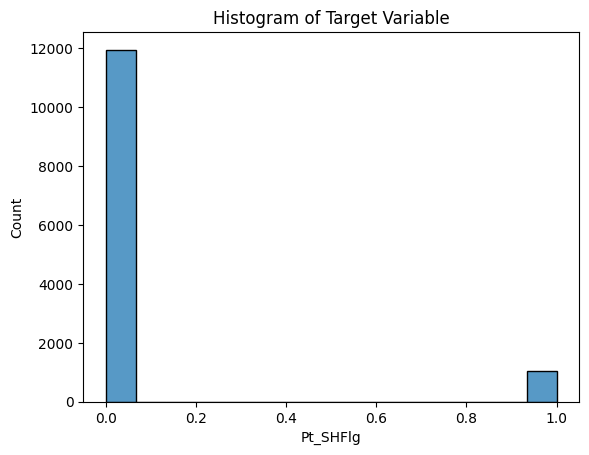

In [ ]:
sns.histplot(data = y)
plt.title("Histogram of Target Variable")
plt.show()

The dataset suffers from a serious data imbalance problem, where the minority class (1) accounts for only 8% of the total dataset. This can lead to biased model predictions and poor performance on category 1, which is the adverse events.

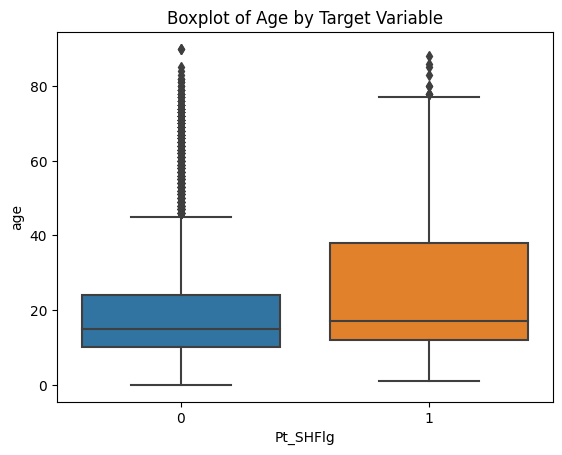

In [ ]:
sns.boxplot(data = df, x = df['Pt_SHFlg'], y = df['age'])
plt.title("Boxplot of Age by Target Variable")
plt.show()

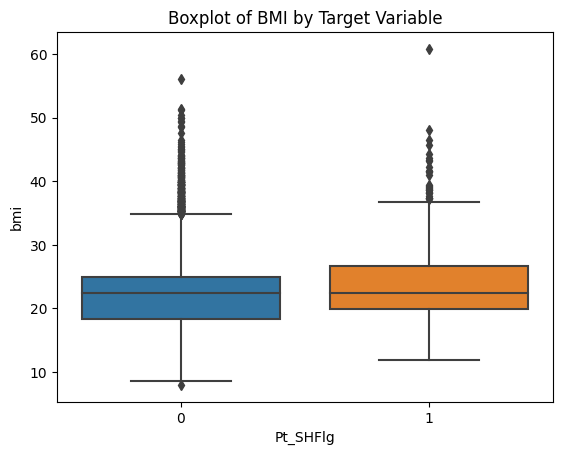

In [ ]:
sns.boxplot(data = df, x = df['Pt_SHFlg'], y = df['bmi'])
plt.title("Boxplot of BMI by Target Variable")
plt.show()

We randomly selected a few of the 167 features and created box plots to compare their distributions between individuals who experienced severe hypoglycemia and those who did not. Based on our preliminary analysis, we observed that both age and BMI appeared to be higher in individuals who experienced severe hypoglycemia compared to those who did not. However, these findings require further investigation and modeling to establish the precise relationship between the features and the target variable.

## Question 1
What are patients' individual risks of severe hypoglycemia events? What the most important feature related to such event?

### Baseline Model

#### Matrix Selection

In our task, false negatives carry a significantly higher cost than false positives. Misclassifying a high-risk hypoglycemic patient as low-risk can have serious consequences, whereas classifying a low-risk patient as high-risk only requires simple interventions such as dietary adjustments, health monitoring, or glucose monitoring. As a result, we prioritize the recall metric over other metrics such as precision or accuracy in our study. Our goal is to minimize the number of false negatives and maximize the identification of high-risk patients, even if this comes at the cost of higher false positive rates.

In [ ]:
# Define evaluation matrices
def eval_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("ROC AUC Score: {:.3f}".format(roc_auc))

Our data presents two main challenges: class imbalance and high dimensionality due to 166 features. To address these issues, we have decided to first focus on feature selection in our baseline model, before addressing the data imbalance. Our goal is to develop a robust model that can accurately predict the target variable while reducing the number of features needed for the prediction. Once we have identified the most relevant features, we can then explore techniques to balance the classes and optimize the model's performance further.

#### Logistic Regression

We selected logistic regression as our first modeling approach due to its simplicity and ability to provide a baseline model. To perform automatic feature selection, we introduced L1 regularization to the logistic regression model. Since the effect of regularization can be impacted by feature scaling, we first performed feature engineering on the raw data and then scaled the features before fitting the model.

In [ ]:
# Standardization
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
# Fit logistics regression
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)
eval_model(y_test, y_pred)

Accuracy: 0.920
Precision: 0.714
Recall: 0.024
ROC AUC Score: 0.511


#### Decision Tree

We have selected decision tree as our second model, and it does not require scaling but requires feature selection. To select the most relevant features, we have decided to use the SelectFromModel method with a feature importance threshold of median. This approach will help us identify the most important features that contribute to the classification task, which we can then use to build an effective decision tree model.

In [ ]:
# Decision Tree Model
dtc = DecisionTreeClassifier()

# Parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

# Select features based on importance
sfm = SelectFromModel(dtc, threshold='median')
sfm.fit(X_train, y_train)

# Transform the data to include only selected features
X_train_important = sfm.transform(X_train)

# Grid search
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_important, y_train)
y_pred = grid_search.predict(sfm.transform(X_test))
eval_model(y_test, y_pred)

Accuracy: 0.917
Precision: 0.000
Recall: 0.000
ROC AUC Score: 0.499


#### Random Forest

Our third model, the random forest, provides a strong baseline model as it does not require feature engineering such as normalization or feature selection. 

In [ ]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Random Forest
rfc = RandomForestClassifier()

# Grid search
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
eval_model(y_test, y_pred)

Accuracy: 0.919
Precision: 0.000
Recall: 0.000
ROC AUC Score: 0.500


We found that both decision trees and random forests have high accuracy but zero recall. This indicates that the issue of data imbalance seriously affects the effectiveness of the model, leading to a bias towards the majority class. To address this, we plan to use resampling techniques. We will evaluate the effectiveness of different resampling methods using logistic regression, which performed best in our baseline model.

### Resampling

We will choose commonly used SMOTE and Deep Generative Models including Variational Auto Encoders and WGAN-GP in the resampling section. SMOTE is a commonly used oversampling technique that generates synthetic samples to balance the class distribution. On the other hand, Variational Auto Encoders (VAE) and Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) are advanced techniques that use deep learning to generate synthetic samples. These models can potentially create more realistic synthetic samples compared to traditional oversampling techniques like SMOTE.

#### SMOTE

In [ ]:
# Perform SMOTE
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)

In [ ]:
# Fit logistics regression
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
lr.fit(X_train_sm, y_train_sm)
y_pred = lr.predict(X_test_sc)
eval_model(y_test, y_pred)

Accuracy: 0.628
Precision: 0.112
Recall: 0.517
ROC AUC Score: 0.577


#### Variational Auto Encoders

In [ ]:
# Perform VAE
X_train_sc = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_train_vae, y_train_vae = VAEify(X_train_sc, y_train)

# Fit logistics regression
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
lr.fit(X_train_vae, y_train_vae)
y_pred = lr.predict(X_test_sc)
eval_model(y_test, y_pred)

Minority and Majority class are:  1 0
Rows of the Org min 165
MIN,MAJ,Desired (842, 165) (9559, 165) 8717
Train Epoch: 1 [0/842 (0%)]	Loss: 119.101967
Train Epoch: 1 [10/842 (1%)]	Loss: 84.958580
Train Epoch: 1 [20/842 (2%)]	Loss: 62.792484
Train Epoch: 1 [30/842 (4%)]	Loss: 33.827206
Train Epoch: 1 [40/842 (5%)]	Loss: 41.191437
Train Epoch: 1 [50/842 (6%)]	Loss: 39.001762
Train Epoch: 1 [60/842 (7%)]	Loss: 38.665714
Train Epoch: 1 [70/842 (8%)]	Loss: 37.232418
Train Epoch: 1 [80/842 (10%)]	Loss: 49.586140
Train Epoch: 1 [90/842 (11%)]	Loss: 36.161274
Train Epoch: 1 [100/842 (12%)]	Loss: 30.883129
Train Epoch: 1 [110/842 (13%)]	Loss: 31.116802
Train Epoch: 1 [120/842 (14%)]	Loss: 52.412262
Train Epoch: 1 [130/842 (15%)]	Loss: 24.321203
Train Epoch: 1 [140/842 (17%)]	Loss: 47.738651
Train Epoch: 1 [150/842 (18%)]	Loss: 68.987259
Train Epoch: 1 [160/842 (19%)]	Loss: 46.360832
Train Epoch: 1 [170/842 (20%)]	Loss: 28.815359
Train Epoch: 1 [180/842 (21%)]	Loss: 42.901260
Train Epoch: 1 [190

#### WGAN-GP

In [ ]:
# Perform WGAN-GP
X_train_wgan, y_train_wgan = WGANify(X_train_sc, y_train)

# Fit logistics regression
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
lr.fit(X_train_wgan, y_train_wgan)
y_pred = lr.predict(X_test_sc)
eval_model(y_test, y_pred)

[ 4890/4890] LG:1.139 LD:1.673 D:1.782 GP:0.007 AC: 0.343 RMSEAVG:0.261 NUM:0.260 SynTraiAuc:0.573 RFAcc:1.000  
Accuracy: 0.801
Precision: 0.141
Recall: 0.284
ROC AUC Score: 0.565


It appears that after applying SMOTE, the precision and recall has improved to 0.112 and 0.517 respectively. The ROC AUC score has also increased slightly to 0.577.

For the Variational Auto Encoder, the accuracy is only 0.090 and the precision is 0.081, which are quite low. However, the recall is very high at 0.991, which means that the model is identifying a large proportion of the high-risk patients, but at the cost of many false positives. The ROC AUC score is only 0.501, which suggests that the model is not performing well overall.

For the WGAN-GP, the accuracy is 0.801, which is relatively high compared to the other models. However, the precision is still quite low at 0.141, and the recall is only 0.284, which means that the model is missing a significant proportion of the high-risk patients. The ROC AUC score is 0.565, which is also lower than the SMOTE model.

SMOTE seems to strike the most balanced performance with improved precision and recall, while VAE has the least false negative rate but very low precision, and WGAN-GP has the least false positive rate but low recall. 

### Cost-sensitive Learning


In addition to the resampling techniques, we are also planning to explore cost-sensitive learning on our three baseline models to see if it can further improve the performance of the models. Cost-sensitive learning is a technique that assigns different misclassification costs to different classes. In our case, we can assign a higher cost to misclassifying a high-risk patient as low-risk, which aligns with the objective of our task.

#### Cost-sensitive Logistic Regression

In [ ]:
# Compute class weights for cost-sensitive learning
class_weights = compute_class_weight('balanced', classes=[0, 1], y = y_train)

# Fit logistics regression
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, class_weight={0: class_weights[0], 1: class_weights[1]})
lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)
eval_model(y_test, y_pred)

Accuracy: 0.674
Precision: 0.133
Recall: 0.545
ROC AUC Score: 0.615


#### Cost-sensitive Decision Tree

In [ ]:
# Decision Tree Model
dtc = DecisionTreeClassifier(class_weight='balanced')

# Parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

# Select features based on importance
sfm = SelectFromModel(dtc, threshold='median')
sfm.fit(X_train, y_train)

# Transform the data to include only selected features
X_train_important = sfm.transform(X_train)

# Grid search
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_important, y_train)
y_pred = grid_search.predict(sfm.transform(X_test))
eval_model(y_test, y_pred)

Accuracy: 0.433
Precision: 0.102
Recall: 0.773
ROC AUC Score: 0.588


#### Cost-sensitive Random Forests

In [ ]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Random Forest
rfc = RandomForestClassifier(class_weight='balanced')

# Grid search
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
eval_model(y_test, y_pred)

Accuracy: 0.713
Precision: 0.151
Recall: 0.550
ROC AUC Score: 0.638


After comparing the performance of our cost-sensitive models to the baseline, we found that they generally performed well and often outperformed the resampled model. In particular, the decision tree model achieved the best recall score of up to 0.77, indicating that it was able to identify a high proportion of high-risk patients. Additionally, the random forest model achieved a new record high ROC AUC score of 0.638, indicating strong overall performance.

### Improved Ensemble Method: Balanced Sampling Strategy

Another approach to address the problem of class imbalance is the improved ensemble method with balanced sampling strategy. This strategy involves using an ensemble of multiple models trained on balanced samples of the dataset to improve the model's overall performance.

One example of such an ensemble method is the BalancedRandomForestClassifier. This algorithm uses a balanced bootstrap sampling approach to create balanced samples of the dataset for each tree in the forest. Another example is the EasyEnsembleClassifier with AdaBoost. This algorithm creates multiple balanced samples of the dataset by randomly undersampling the majority class and then applies AdaBoost to train a series of weak learners on each sample. 

Ensemble methods with a balanced sampling strategy can be particularly effective for datasets with imbalanced classes, where the number of positive samples is much smaller than the number of negative samples. By using a balanced sampling approach, these methods can help to improve the model's performance and address the issue of class imbalance.

#### Random Forest with Balanced Sampling Strategy


In [ ]:
# Balanced Random Forest Classifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Use recall score as selection criterion
scoring = make_scorer(recall_score)
brf = BalancedRandomForestClassifier(random_state=42)
grid_search = GridSearchCV(brf, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
eval_model(y_test, y_pred)

Accuracy: 0.596
Precision: 0.124
Recall: 0.659
ROC AUC Score: 0.625


In [ ]:
# Calculate feature importance
brfc = grid_search.best_estimator_
importances = brfc.feature_importances_
feature_names = list(X_train.columns) 
feature_importances = list(zip(feature_names, importances))
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

#### AdaBoost with Balanced Sampling Strategy

In [ ]:
# Easy Ensemble Classifier
# Parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'base_estimator__learning_rate': [0.1, 0.5, 1]
}

# Use recall score as selection criterion
scoring = make_scorer(recall_score)
ee = EasyEnsembleClassifier(base_estimator=AdaBoostClassifier())
grid_search = GridSearchCV(ee, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
eval_model(y_test, y_pred)

Accuracy: 0.618
Precision: 0.121
Recall: 0.592
ROC AUC Score: 0.606


### Anomaly Detection

Anomaly Detection is a powerful technique that can be used to identify rare events in a dataset by detecting patterns that deviate significantly from the norm. This approach can be particularly useful for addressing the problem of data imbalance, as the majority of the class can be considered as the "regular events" and the minority class as the "anomalies".

It's important to note that Anomaly Detection algorithms are typically unsupervised and do not require labeled data to train the model. However, it can be challenging to tune the hyperparameters of these algorithms, as there is no ground truth for the anomalies in the dataset. In this part, we are going to perform three anomaly detection method to see their performance, including one-class SVM, isolation forest and local outlier factor (LOF).

#### One-class SVM

One-Class SVM is a distance-based algorithm that requires normalized data for optimal performance. As SVM can perform well in high-dimensional spaces, we don't need feature selection.

In [ ]:
# Train OneClassSVM model
svm = svm.OneClassSVM(gamma='scale', nu=0.01).fit(X_train_sc[y_train.reset_index(drop=True) == 0])

# Make predictions on test data
y_pred = svm.predict(X_test_sc)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
eval_model(y_test, y_pred)

Accuracy: 0.865
Precision: 0.131
Recall: 0.118
ROC AUC Score: 0.525


#### Isolation Forest

Isolation Forest is a tree-based algorithm that randomly selects features and splits the data at random points, making it robust to irrelevant and correlated features. And because Isolation Forest is not a distance-based algorithm, it does not require scaled data. 

In [ ]:
iforest = IsolationForest(contamination=float(0.05), random_state=42).fit(X_train_sc[y_train.reset_index(drop=True) == 0])

# Make predictions on test data
y_pred = iforest.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
eval_model(y_test, y_pred)

Accuracy: 0.774
Precision: 0.128
Recall: 0.308
ROC AUC Score: 0.561


#### Local Outlier Factor

Since LOF is a similarity-based algorithm, it requires normalized data for optimal performance. However, unlike some other algorithms, LOF is relatively insensitive to irrelevant or redundant features. This means that feature selection is not strictly necessary for LOF to perform well, even in high-dimensional spaces.

In [ ]:
def lof_predict(model, trainX, testX):
  composite = vstack((trainX, testX))
  yhat = model.fit_predict(composite)
  return yhat[len(trainX):]

lof = LocalOutlierFactor(contamination = 0.05)
y_pred = lof_predict(lof, X_train_sc[y_train.reset_index(drop=True) == 0], X_test_sc)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
eval_model(y_test, y_pred)

Accuracy: 0.877
Precision: 0.113
Recall: 0.076
ROC AUC Score: 0.512


After evaluating three different models, we have found that the isolation forest algorithm is achieving the best performance. 

### Final Model

|    | Model                                   | Accuracy | Precision | Recall | AUC score |
|---:|:----------------------------------------|---------:|----------:|-------:|----------:|
| 1  | Baseline: Logistic Regression            | 0.920    | 0.714     | 0.024  | 0.511     |
|    | Baseline: Decision Tree                  | 0.917    | 0.000     | 0.000  | 0.499     |
|    | Baseline: Random Forest                  | 0.919    | 0.000     | 0.000  | 0.500     |
| 2  | Resampling: SMOTE + Logistic Regression  | 0.628    | 0.112     | 0.517  | 0.577     |
|    | Resampling: VAE + Logistic Regression    | 0.090    | 0.081     | 0.991  | 0.501     |
|    | Resampling: WGAN-GP + Logistic Regression| 0.801    | 0.141     | 0.284  | 0.565     |
| 3  | Cost-sensitive Logistics Regression      | 0.674    | 0.133     | 0.545  | 0.615     |
|    | Cost-sensitive Decision Tree             | 0.433    | 0.102     | 0.773  | 0.588     |
|    | Cost-sensitive Random Forest             | 0.713    | 0.151     | 0.550  | 0.638     |
| 4  | Random Forest with Balanced Sampling     | 0.596    | 0.124     | 0.659  | 0.625     |
|    | AdaBoost with Balanced Sampling          | 0.618    | 0.121     | 0.592  | 0.606     |
| 5  | Anomaly Detection: One Class SVM         | 0.870    | 0.132     | 0.109  | 0.523     |
|    | Anomaly Detection: Isolation Forest      | 0.847    | 0.159     | 0.209  | 0.556     |
|    | Anomaly Detection: Local Outlier Factor  | 0.840    | 0.124     | 0.161  | 0.530     |

After analyzing all the model metrics, we have concluded that the random forest model with balanced sampling has the most favorable performance. It achieved a recall score that ranks in the top three of all models, while maintaining a decent auc score and accuracy. Therefore, we can say that this model has the best equilibrium effect compared to other models.

#### Model Interpretation

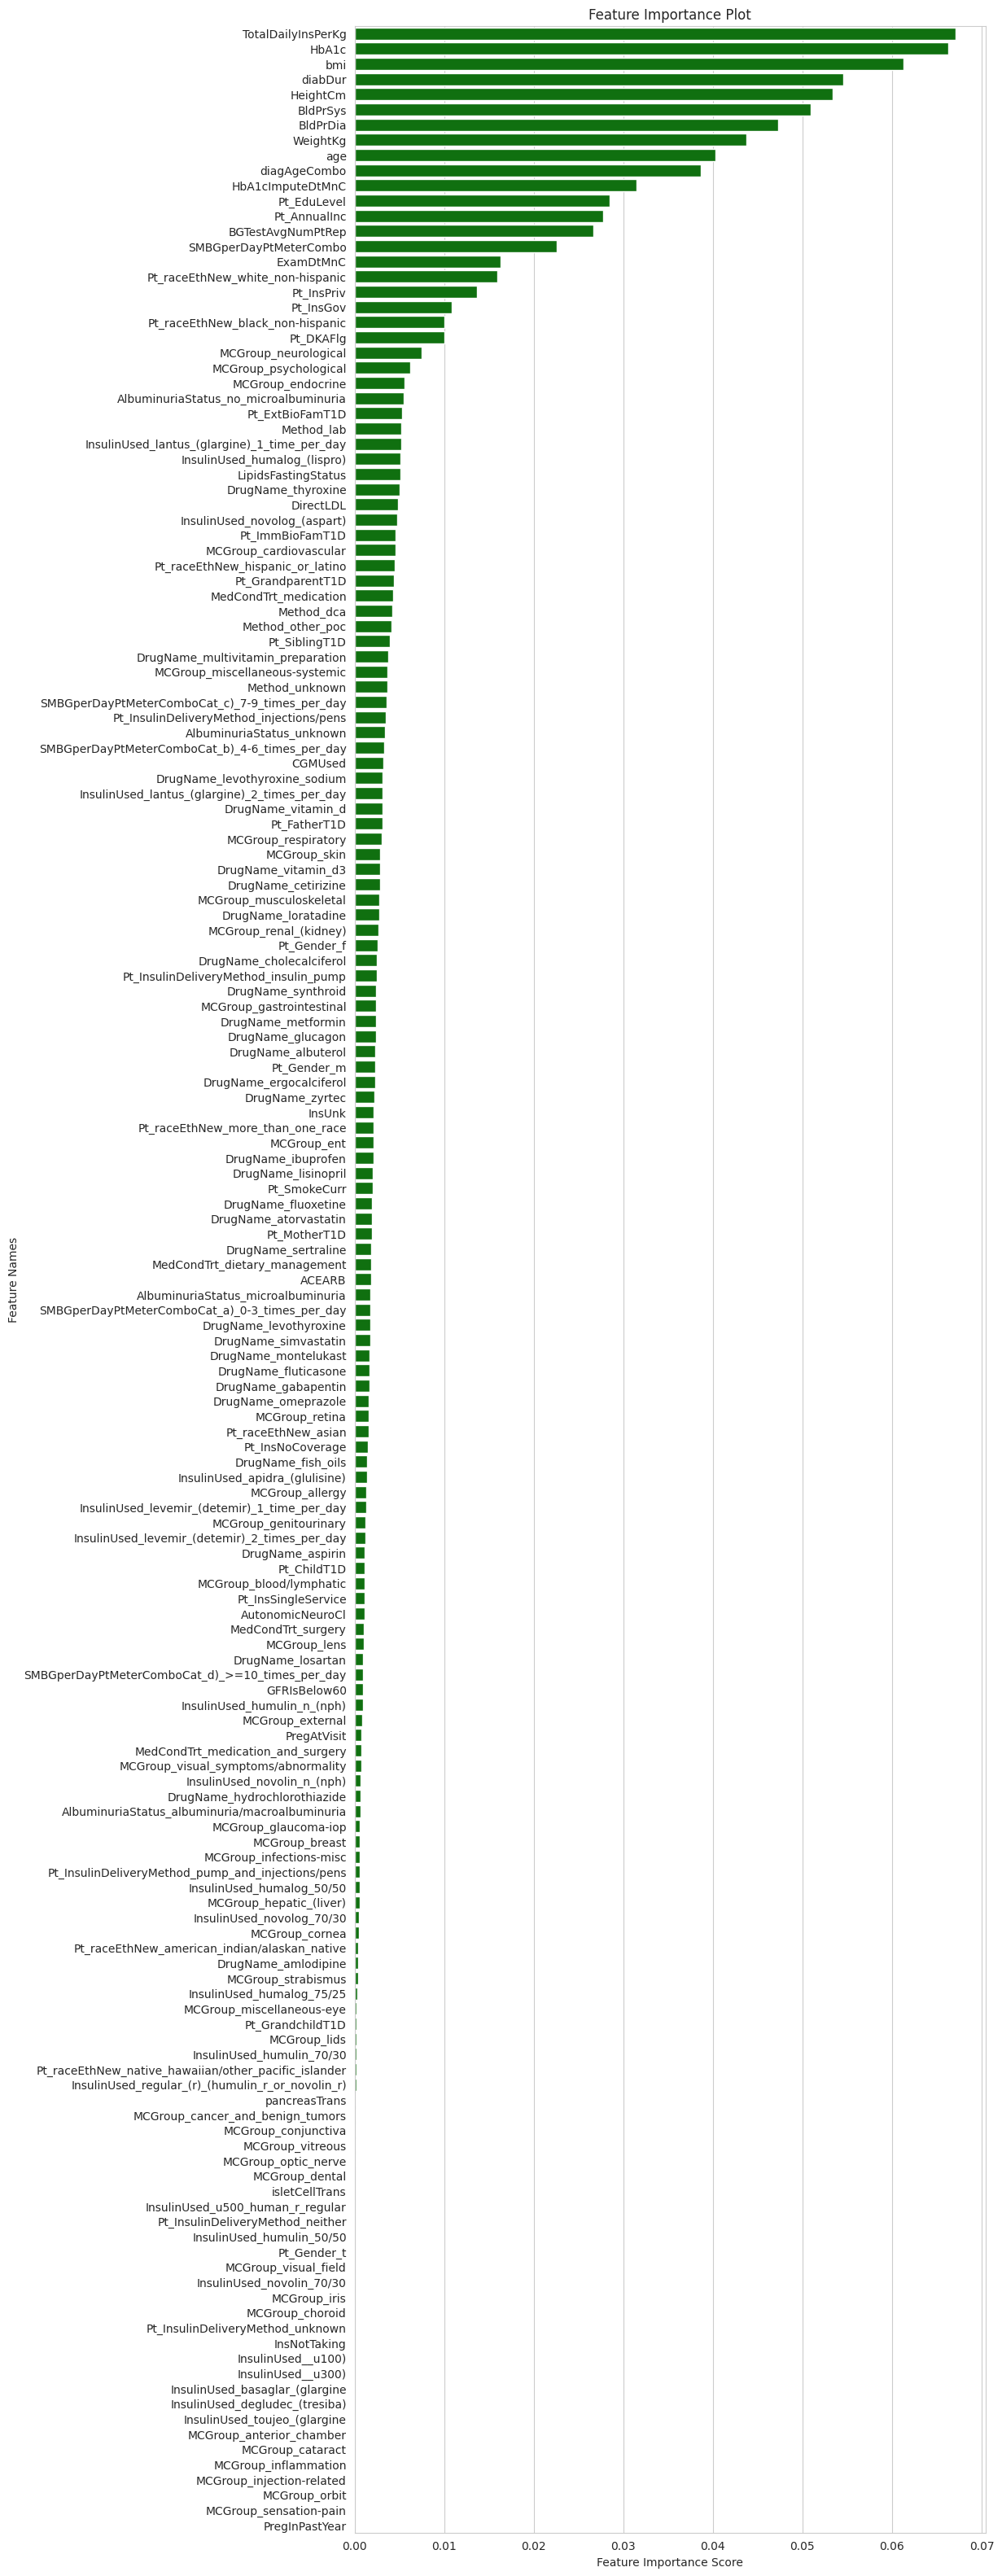

In [ ]:
feature_names, importance_scores = zip(*sorted_feature_importances)

# create a bar plot using seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 40))
sns.barplot(x=list(importance_scores), y=list(feature_names), color="g")
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Names')
plt.title('Feature Importance Plot')
plt.show()

What are patients' individual risks of severe hypoglycemia events? What the most important feature related to such event? 

Regarding the individual risks of severe hypoglycemia events in patients, it can vary depending on various factors, such as the medication, lifestyle, and individual health conditions. 

As for the most important feature related to such an event, project suggests that the average total units of insulin per day per kg of body weight is the most crucial factor. Other important features related to severe hypoglycemia events include HbA1c (%), BMI, duration of T1D, height, systolic blood pressure, diastolic blood pressure, weight, and age. It is important to note that these factors can vary depending on individual patients and their medical history. 

## Question 2
Whether the use of CGM will be effective in suppressing occurence of severe hypoglycemia events?

Random Forest Feature Importance is a useful metric for ranking the relative importance of features in a dataset, but it does not provide a direct measure of the relationship between each feature and the target variable. In order to gain a better understanding of the relationship between CGM Used and the target variable, as well as the effects of other important features, we can run a logistic regression model. By including CGM Used and the top important features as predictors, we can examine how each feature contributes to the model's ability to predict the target variable. This approach can provide valuable insights into the relationships between the features and the target variable, as well as help us to better understand the relative importance of each feature in predicting the outcome.

In [ ]:
df2 = df.copy()
df2['treatment'] = df['CGMUsed']
df2['outcome'] = df['Pt_SHFlg']

In [ ]:
import statsmodels.api as sm

# Defining X and y
y=df['Pt_SHFlg']
X=df[['CGMUsed', 'TotalDailyInsPerKg', 'HeightCm', 'WeightKg', 'diabDur', 'bmi', 'age', 'BldPrSys', 'BldPrDia', 'diagAgeCombo', 'HbA1cImputeDtMnC']]
X=sm.add_constant(X)
#Splitting the dataset
model=sm.Logit(y, X)
result=model.fit()
print(result.summary())
# Fetching the statistics
stat_df=pd.DataFrame({'coefficients':result.params, 'p-value': result.pvalues, 'odds_ratio': np.exp(result.params)})
# Condition for significant parameters
significant_params=stat_df[stat_df['p-value']<=0.05].index
significant_params= significant_params.drop('const')
significant_params

Optimization terminated successfully.
         Current function value: 0.275925
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Pt_SHFlg   No. Observations:                13002
Model:                          Logit   Df Residuals:                    12990
Method:                           MLE   Df Model:                           11
Date:                Sun, 30 Apr 2023   Pseudo R-squ.:                 0.01867
Time:                        17:16:53   Log-Likelihood:                -3587.6
converged:                       True   LL-Null:                       -3655.8
Covariance Type:            nonrobust   LLR p-value:                 8.284e-24
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.4086      0.961     -5.625      0.000      -7.293      -3.524
CGMUs

Index(['CGMUsed', 'TotalDailyInsPerKg', 'bmi'], dtype='object')

Whether the use of CGM will be effective in suppressing occurence of severe hypoglycemia events?

Yes. Log-odds of experiencing hypoglycemia events is 0.3 lower for patients who use CGM compared to those who do not use CGM. Our study does suggest an association between the use of CGM and a lower risk of experiencing severe hypoglycemia events.

References:
1. https://github.com/rajoy99/osman
2. https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_6_ImbalancedLearning/Ensembling.html#random-forest
3. https://medium.com/swlh/logistic-regression-case-study-statistical-analysis-in-python-d5e3f4efbb30
4. https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html
5. https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e